In [ ]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
building_info_df = pd.read_csv('building_info.csv')

ko2en_dict = {
 '건물번호': 'b_num',
 '일시': 'date',
 '기온(°C)': 'tmp',
 '강수량(mm)': 'rain',
 '풍속(m/s)': 'wind',
 '습도(%)': 'hum',
 '일조(hr)': 'sunshine',
 '일사(MJ/m2)': 'solar',
 '전력소비량(kWh)': 'power_consumption',
 '건물유형': 'b_type',
 '연면적(m2)': 'total_area',
 '냉방면적(m2)': 'cooling_area',
 '태양광용량(kW)': 'solar_capacity',
 'ESS저장용량(kWh)': 'ess_capacity',
 'PCS용량(kW)': 'pcs_capacity',
}

def rename_dataframe_columns(df, mapping_dict):
    return df.rename(columns=mapping_dict).copy()

train_df = rename_dataframe_columns(train_df, ko2en_dict)
test_df = rename_dataframe_columns(test_df, ko2en_dict)
building_info_df = rename_dataframe_columns(building_info_df, ko2en_dict)

building_info_df['solar_capacity']= building_info_df['solar_capacity'].replace('-', 0)
building_info_df['ess_capacity']= building_info_df['ess_capacity'].replace('-', 0)
building_info_df['pcs_capacity']= building_info_df['pcs_capacity'].replace('-', 0)
for col in ['solar_capacity', 'ess_capacity', 'pcs_capacity']:
    building_info_df[col] = pd.to_numeric(building_info_df[col], errors='coerce')

train_df = pd.merge(train_df, building_info_df, on='b_num', how='left')
test_df = pd.merge(test_df, building_info_df, on='b_num', how='left')

def plot_column_at_time_add_line_with_week(df, column_name, b_num):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H')
    df['weekday'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['weekday'] >= 5
    

    start_index = 0
    plt.figure(figsize=(30,10))

    # Iterate through the dataframe to plot segments
    # Include the current point to connect segments
    for i in range(1, len(df)):
        if df['is_weekend'].iloc[i] != df['is_weekend'].iloc[i-1]:
            segment = df.iloc[start_index:i+1]
            color = 'red' if segment['is_weekend'].iloc[0] else 'black'
            plt.plot(segment['date'], segment[column_name], color=color)
            start_index = i


    # last segment
    segment = df.iloc[start_index:]
    color = 'red' if segment['is_weekend'].iloc[0] else 'black'
    plt.plot(segment['date'], segment[column_name], color=color)

    # vertical lines
    for date in df['date'].dt.normalize().unique():
        if date.weekday() == 0 or date.weekday() == 6: # Monday or Sunday
            plt.axvline(date, color='green', linestyle='--', linewidth=0.8)
        else:
            plt.axvline(date, color='black', linestyle='--', linewidth=0.8)

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.title(f'{column_name} over time for Building {b_num}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.show()

def plot_batch_of_buildings_with_week(df, column_name, b_num_list):
    for num in b_num_list:
        temp = df[df['b_num'] == num].copy()
        plot_column_at_time_add_line_with_week(temp, column_name, num)


display(train_df.head())
display(test_df.head())

#preprocessing

X = train_df.drop(columns=['power_consumption', 'date','num_date_time', 'b_type', 'sunshine','solar'])

Y = train_df['power_consumption']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_input = test_df.drop(columns=['date','num_date_time', 'b_type'])
X_num = test_df['num_date_time']

display(X_train.head())
display(X_test.head())


#모델 학습
model = xgb()
model.fit(X_train, Y_train)
#성능 평가
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

#결과
Y_output = model.predict(X_input)
answer = pd.DataFrame({
    'num_data_time' : X_num,
    'answer' : Y_output
})
print('Answer : ')
display(answer)


,num_date_time,b_num,date,tmp,rain,wind,hum,sunshine,solar,power_consumption,b_type,total_area,cooling_area,solar_capacity,ess_capacity,pcs_capacity
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,호텔,82912.71,77586.0,0.0,0.0,0
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,호텔,82912.71,77586.0,0.0,0.0,0
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,호텔,82912.71,77586.0,0.0,0.0,0
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,호텔,82912.71,77586.0,0.0,0.0,0
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,호텔,82912.71,77586.0,0.0,0.0,0


,num_date_time,b_num,date,tmp,rain,wind,hum,b_type,total_area,cooling_area,solar_capacity,ess_capacity,pcs_capacity
0,1_20240825 00,1,20240825 00,26.5,0.0,0.7,80.0,호텔,82912.71,77586.0,0.0,0.0,0
1,1_20240825 01,1,20240825 01,26.1,0.0,0.0,80.0,호텔,82912.71,77586.0,0.0,0.0,0
2,1_20240825 02,1,20240825 02,25.9,0.0,0.3,83.0,호텔,82912.71,77586.0,0.0,0.0,0
3,1_20240825 03,1,20240825 03,25.7,0.0,1.1,83.0,호텔,82912.71,77586.0,0.0,0.0,0
4,1_20240825 04,1,20240825 04,25.5,0.0,1.0,86.0,호텔,82912.71,77586.0,0.0,0.0,0


,b_num,tmp,rain,wind,hum,total_area,cooling_area,solar_capacity,ess_capacity,pcs_capacity
48018,24,26.5,0.0,1.3,74.0,201828.93,161463.14,953.40,0.0,0
79010,39,27.8,0.0,2.5,90.0,99347.35,59803.08,74.25,0.0,0
118547,59,25.8,0.0,2.5,65.0,169052.00,33867.00,0.00,0.0,0
163097,80,29.4,0.0,2.6,76.0,373141.00,75340.00,790.08,201.1,101
26697,14,19.7,0.0,0.8,82.0,504332.00,339131.00,849.78,101.5,101


,b_num,tmp,rain,wind,hum,total_area,cooling_area,solar_capacity,ess_capacity,pcs_capacity
184895,91,26.1,0.0,0.8,91.0,364652.77,243493.983,0.0,0.0,0
187594,92,26.6,3.1,6.4,97.0,27915.29,5628.000,322.9,209.0,100
119228,59,22.9,1.3,0.4,96.0,169052.00,33867.000,0.0,0.0,0
148570,73,30.1,0.0,1.5,75.0,139042.61,85996.600,103.0,0.0,0
150165,74,28.1,0.0,1.9,83.0,146518.00,98493.000,0.0,0.0,0


MSE: 634397.16
RMSE: 796.49
R²: 0.9530
Answer : 


,num_data_time,answer
0,1_20240825 00,4840.091309
1,1_20240825 01,4827.512695
2,1_20240825 02,4891.096680
3,1_20240825 03,4967.802246
4,1_20240825 04,4945.145508
...,...,...
16795,100_20240831 19,1692.713867
16796,100_20240831 20,1565.992798
16797,100_20240831 21,1542.130249
16798,100_20240831 22,1529.368164


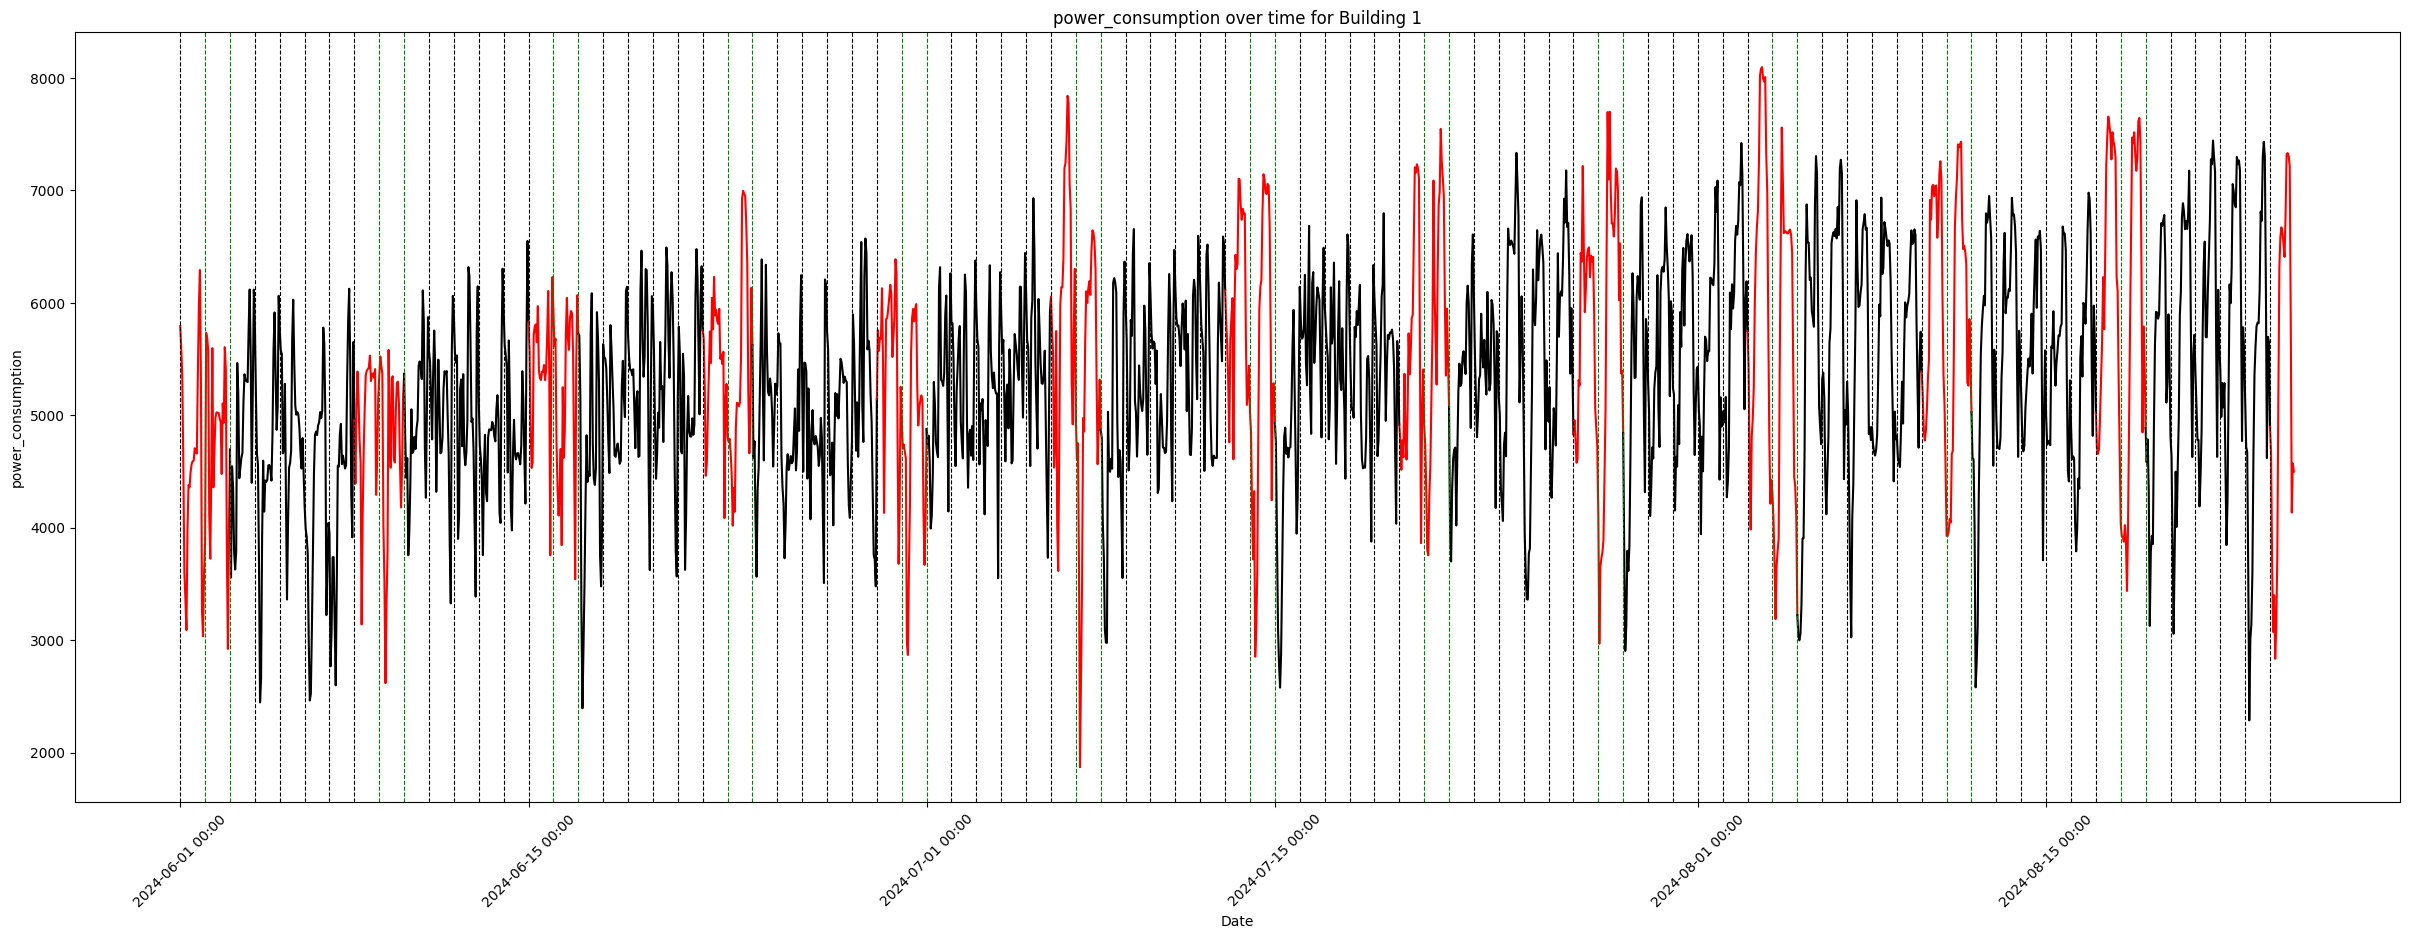

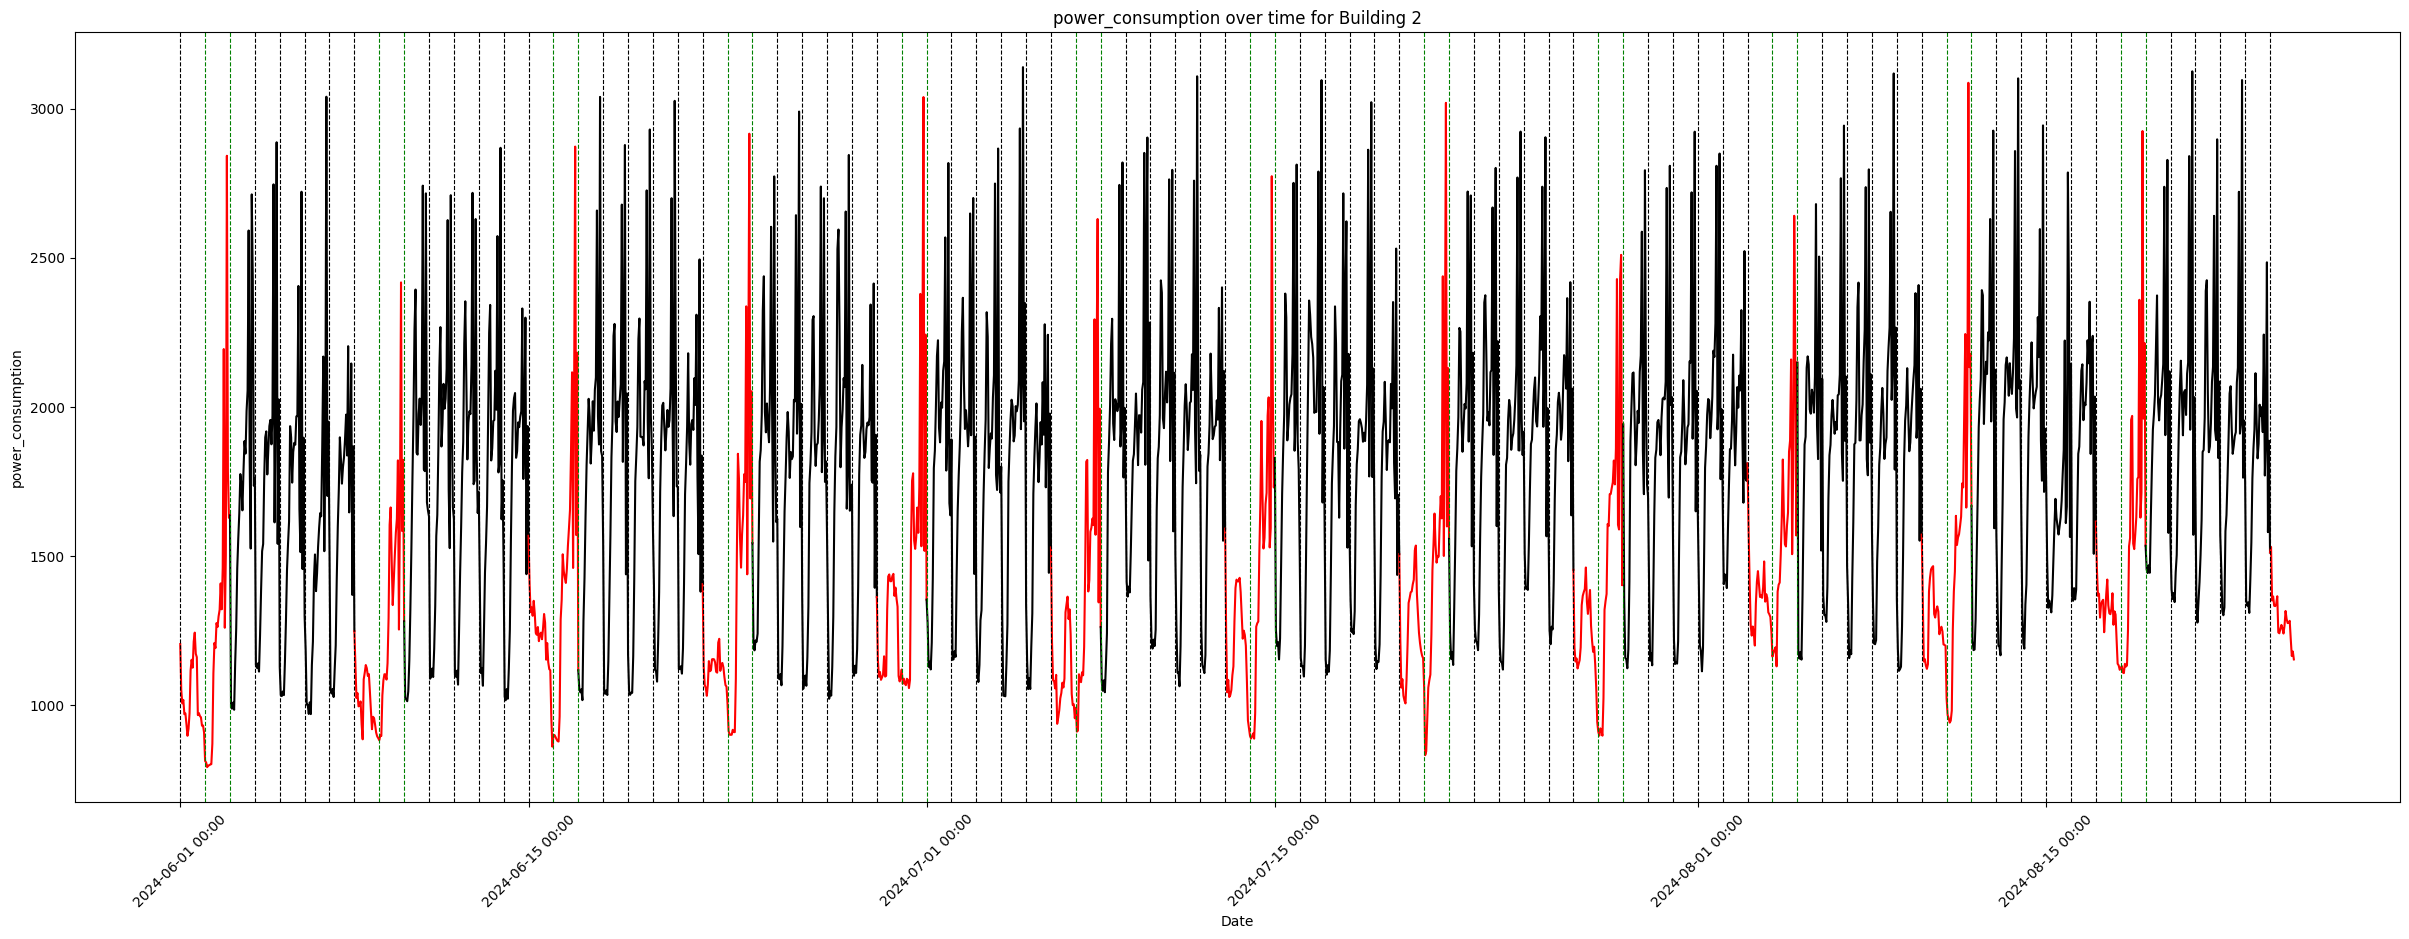

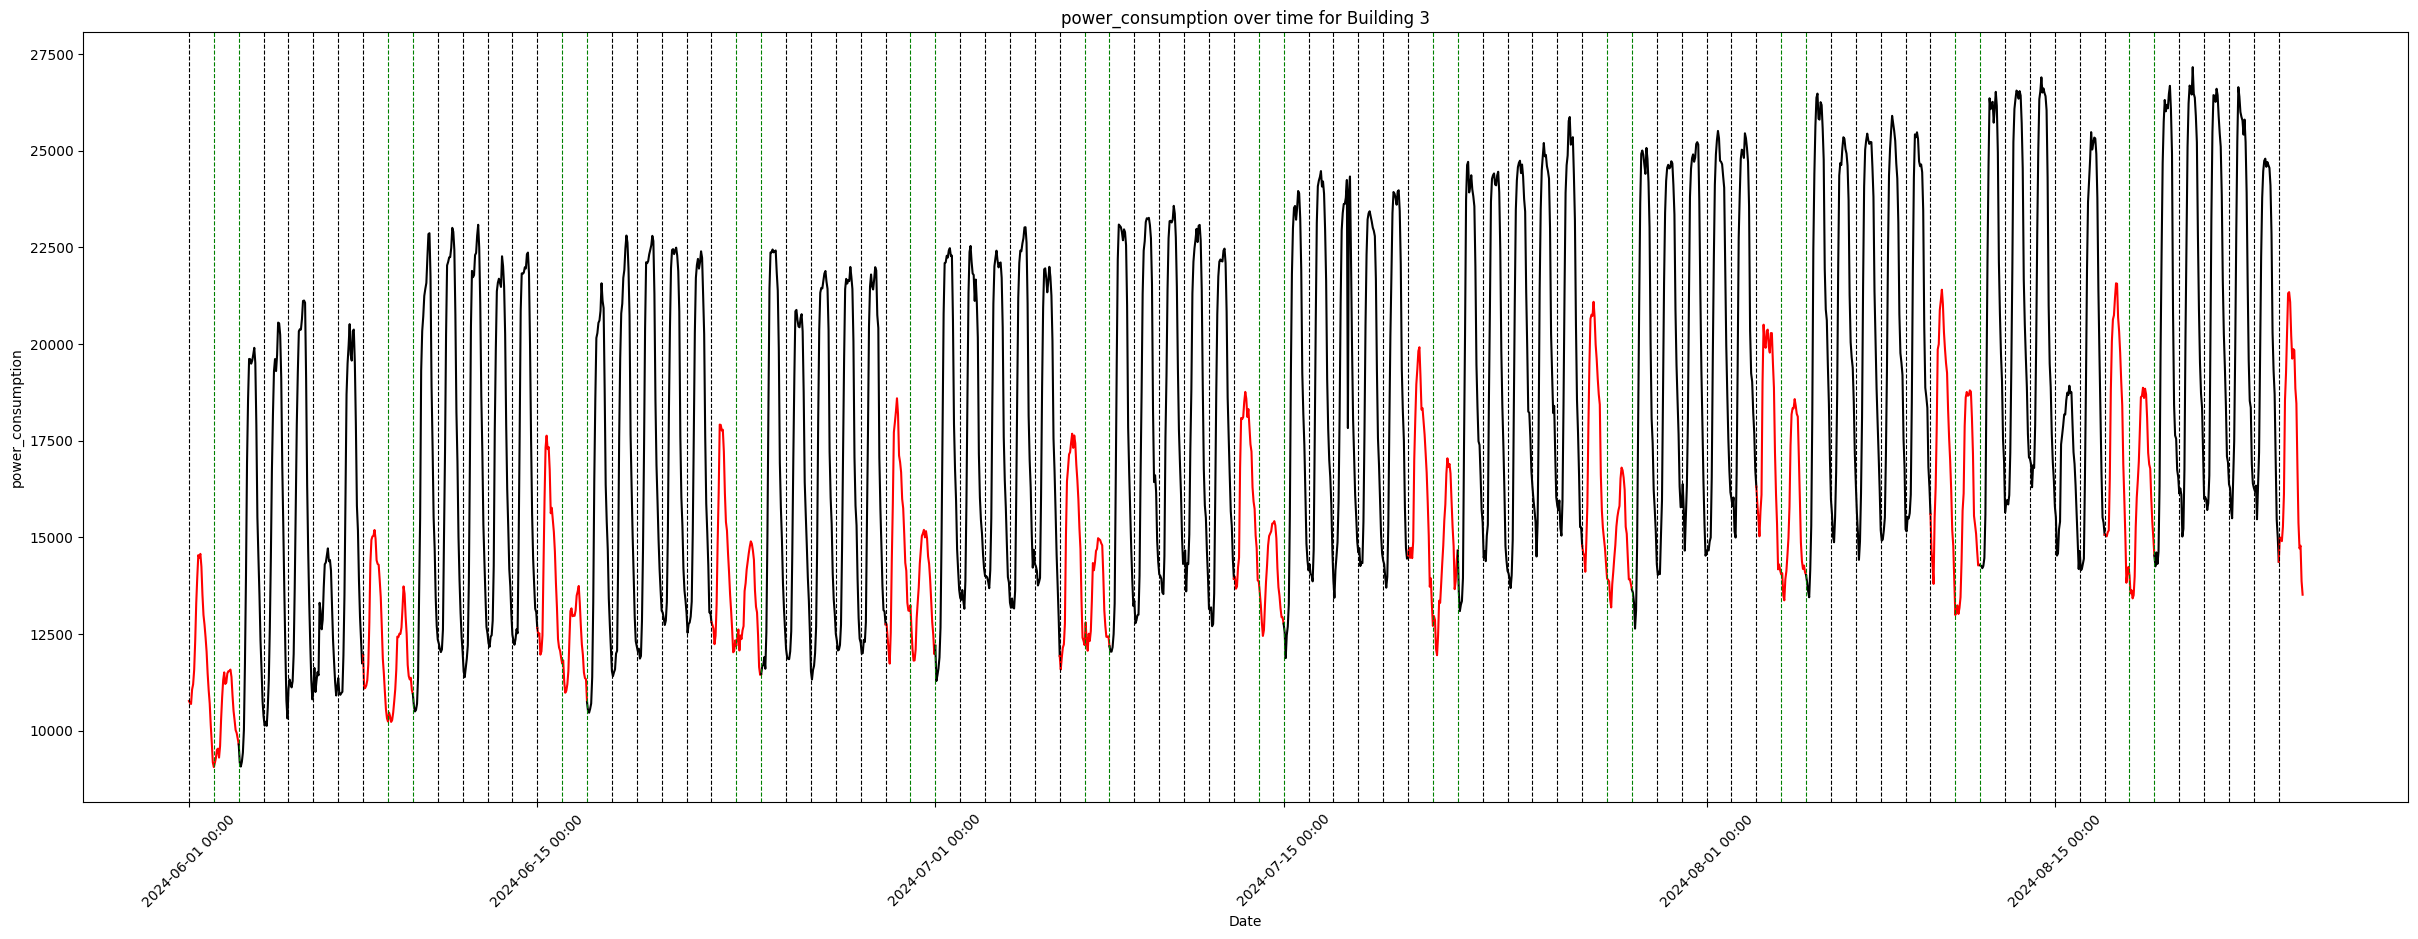

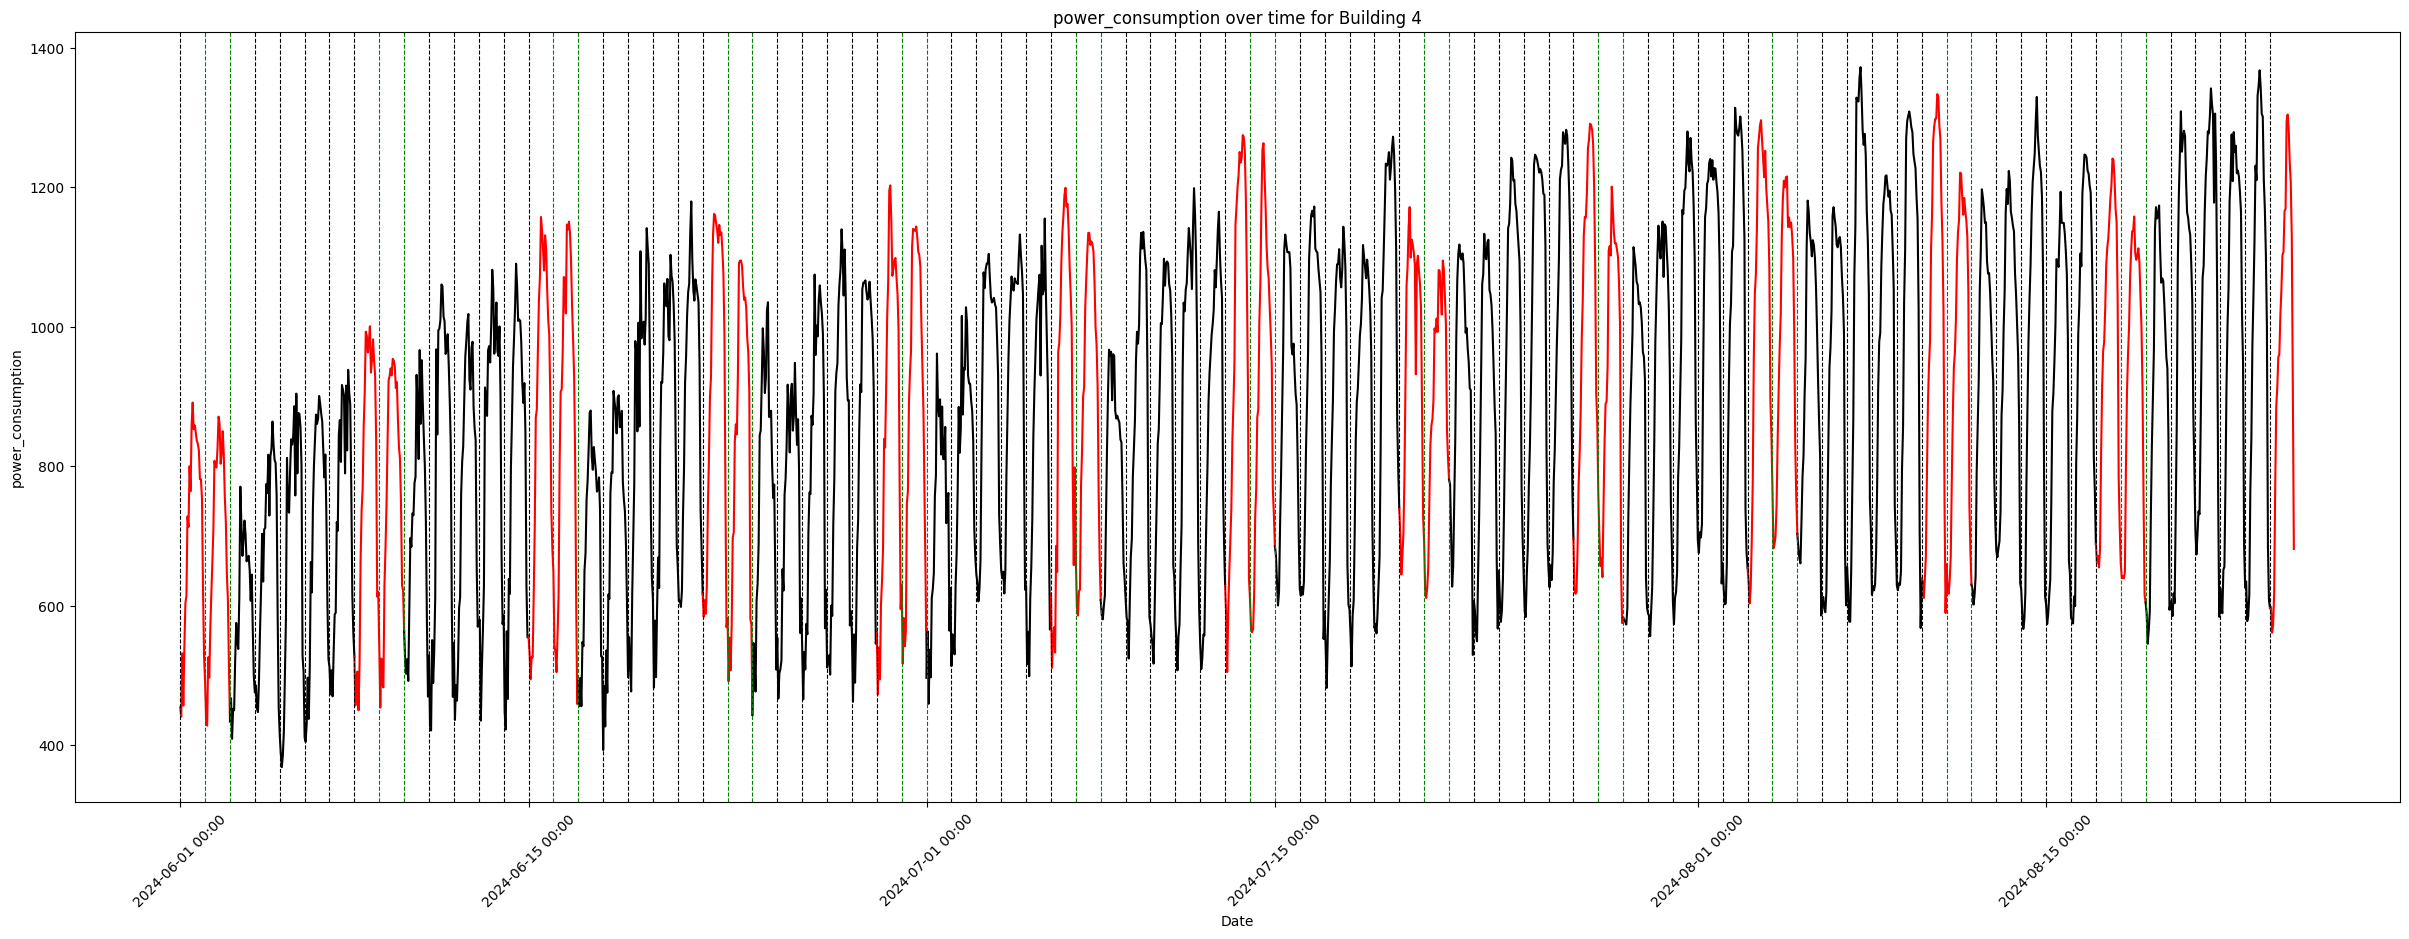

In [29]:
min_index = 1
max_index = 5
plot_batch_of_buildings_with_week(train_df, 'power_consumption',list(range(min_index, max_index)))

In [25]:
demo = pd.read_csv('train.csv')
demo = rename_dataframe_columns(demo, ko2en_dict)
demo['date'] = pd.to_datetime(demo['date'])
demo['weekday'] = demo['date'].dt.day_of_week
demo['is_weekend'] = demo['weekday'] >= 5
display(demo.head())

,num_date_time,b_num,date,tmp,rain,wind,hum,sunshine,solar,power_consumption,weekday,is_weekend
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,5,True
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,5,True
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,5,True
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,5,True
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,5,True
